# Unsupervised Learning Modeling

This notebook carries out basic unsupervised learning modeling of the [Dataset of songs in Spotify](https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify).

Note that the present notebook is not tracked with Weights and Biases. To see how to track notebooks, have a look at [`EDA_Tracked.ipynb`](EDA_Tracked.ipynb).

Table of contents:

1. [Basic EDA](#1.-Basic-EDA)
2. [Processing](#2.-Processing)
    - [Impute `loudness` with KNN](#Impute-`loudness`-with-KNN)
    - [Define Types of Columns](#Define-Types-of-Columns)
    - [Encode Numericals: Transform if Skewed](#Encode-Numericals:-Transform-if-Skewed)
    - [Encode Categoricals](#Encode-Categoricals)
    - [Encode Text Features](#Encode-Text-Features)
    - [Assemble All Columns and Scale](#Assemble-All-Columns-and-Scale)
    - [Encode Targets](#Encode-Targets)
3. [Clustering](#Clustering)


## 1. Basic EDA

In [1]:
import sys
import itertools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_parquet('../dataset/genres_mod.parquet')

In [4]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,genre,song_name,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,audio_features,124539,4,Dark Trap,Mercury: Retrograde,None
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,audio_features,224427,4,Dark Trap,Pathology,None
2,0.850,0.893,5,NaN,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,audio_features,98821,4,Dark Trap,Symbiote,None
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,audio_features,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),None
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,audio_features,123298,4,Dark Trap,Venom,None


In [5]:
# Missing values in
# - loudness
# - song_name
# - title (album?)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42896 entries, 0 to 42895
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42896 non-null  float64
 1   energy            42896 non-null  float64
 2   key               42896 non-null  int64  
 3   loudness          33726 non-null  float64
 4   mode              42896 non-null  int64  
 5   speechiness       42896 non-null  float64
 6   acousticness      42896 non-null  float64
 7   instrumentalness  42896 non-null  float64
 8   liveness          42896 non-null  float64
 9   valence           42896 non-null  float64
 10  tempo             42896 non-null  float64
 11  type              42896 non-null  object 
 12  duration_ms       42896 non-null  int64  
 13  time_signature    42896 non-null  int64  
 14  genre             42896 non-null  object 
 15  song_name         21811 non-null  object 
 16  title             21079 non-null  object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,42896.0,0.639336,0.156585,0.065100,0.52400,0.64600,0.7660,0.988
energy,42896.0,0.762560,0.183691,0.000243,0.63200,0.80300,0.9230,1.000
key,42896.0,5.368566,3.664993,0.000000,1.00000,6.00000,9.0000,11.000
loudness,33726.0,-6.463899,2.938171,-32.929000,-8.16500,-6.22850,-4.5200,3.148
mode,42896.0,0.549492,0.497550,0.000000,0.00000,1.00000,1.0000,1.000
speechiness,42896.0,0.136446,0.125976,0.022700,0.04910,0.07540,0.1930,0.946
acousticness,42896.0,0.096260,0.170843,0.000001,0.00173,0.01640,0.1070,0.988
instrumentalness,42896.0,0.283229,0.370810,0.000000,0.00000,0.00596,0.7220,0.989
liveness,42896.0,0.214080,0.175463,0.010700,0.09960,0.13500,0.2940,0.988
valence,42896.0,0.357170,0.233255,0.018700,0.16100,0.32200,0.5220,0.988


<AxesSubplot:>

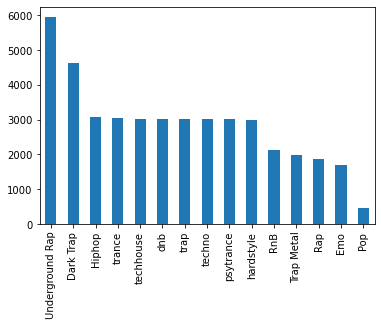

In [7]:
df['genre'].value_counts().plot(kind='bar')

In [8]:
df['song_name']

0                                  Mercury: Retrograde
1                                            Pathology
2                                             Symbiote
3        ProductOfDrugs (Prod. The Virus and Antidote)
4                                                Venom
                             ...                      
42891                                       Bang Bros!
42892                                             None
42893                                             None
42894                               Southern Hostility
42895                                             None
Name: song_name, Length: 42896, dtype: object

<AxesSubplot:ylabel='Frequency'>

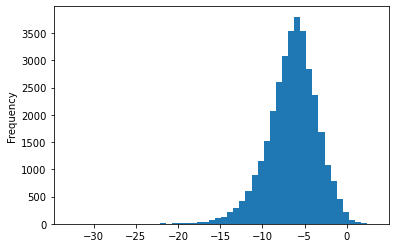

In [9]:
df['loudness'].plot(kind='hist', bins=50)

<AxesSubplot:>

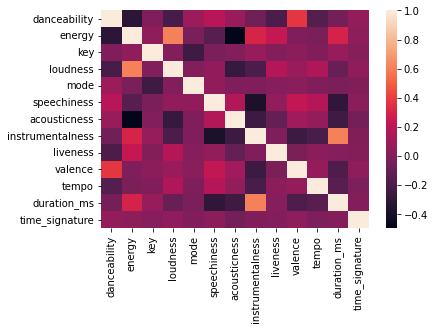

In [10]:
sns.heatmap(df.corr())

In [11]:
# Loudness seems to be quite correlated
# with some variables:
# energy, liveliness, acousticness, daceablity, instrumentalness
# It seems reasonable to use KNN to impute the missing values
df.corr()['loudness'].sort_values()

acousticness       -0.285024
danceability       -0.215901
instrumentalness   -0.193452
duration_ms        -0.096771
mode               -0.005488
key                -0.004448
time_signature      0.044419
speechiness         0.049049
valence             0.081257
tempo               0.152138
liveness            0.170606
energy              0.603524
loudness            1.000000
Name: loudness, dtype: float64

In [12]:
df['time_signature'].value_counts()

4    40999
3     1227
5      519
1      151
Name: time_signature, dtype: int64

In [13]:
df['key'].value_counts()

1     7641
7     4332
11    4197
6     3767
0     3520
8     3405
10    3294
9     3293
2     3093
5     3047
4     2397
3      910
Name: key, dtype: int64

In [14]:
df['mode'].value_counts()

1    23571
0    19325
Name: mode, dtype: int64

In [15]:
# Get all possible genres
# Genre is the target variable in the dataset
df['genre'].unique()

array(['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB',
       'Pop', 'Hiphop', 'techhouse', 'techno', 'trance', 'psytrance',
       'trap', 'dnb', 'hardstyle'], dtype=object)

In [16]:
# All type fields are 'audio_features'
df['type'].value_counts()

audio_features    42896
Name: type, dtype: int64

## 2. Processing

In [17]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

In [18]:
# A minimal feature engineering step: a new feature = song name + title
df['title'].fillna(value='', inplace=True)
df['song_name'].fillna(value='', inplace=True)
df['text_feature'] = df['title'] + ' ' + df['song_name']
X = df.drop(['title', 'song_name', 'type'], axis=1)

In [19]:
# We can see that after merging title and song_name
# the only feature with NAs remains to be loudness
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41975 entries, 0 to 41974
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      41975 non-null  float64
 1   energy            41975 non-null  float64
 2   key               41975 non-null  int64  
 3   loudness          32968 non-null  float64
 4   mode              41975 non-null  int64  
 5   speechiness       41975 non-null  float64
 6   acousticness      41975 non-null  float64
 7   instrumentalness  41975 non-null  float64
 8   liveness          41975 non-null  float64
 9   valence           41975 non-null  float64
 10  tempo             41975 non-null  float64
 11  duration_ms       41975 non-null  int64  
 12  time_signature    41975 non-null  int64  
 13  genre             41975 non-null  object 
 14  text_feature      41975 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 4.8+ MB


### Impute `loudness` with KNN

In [20]:
# Remove original target and text
X_tmp = X.drop(['text_feature', 'genre'], axis=1)

In [21]:
# Encode whether loudness is available or not
X_tmp['has_loudness'] = (X_tmp['loudness'].isna() == False)

In [22]:
# Get training samples
X_train = X_tmp[X_tmp.has_loudness==True].drop(['loudness'], axis=1)
y_train = X_tmp[X_tmp.has_loudness==True]['loudness']

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Scale numerical values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Intantiate a KNN Regressor
knnr = KNeighborsRegressor()

# Grid search
search = GridSearchCV(estimator=knnr,
                      param_grid=param_grid,
                      cv=5,
                      scoring='neg_mean_squared_error')

# Find best hyperparameters and best estimator pipeline
search.fit(X_train_scaled, y_train)
estimator = search.best_estimator_

In [25]:
search.best_score_

-4.779581678746105

In [26]:
search.best_params_

{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

In [27]:
# Predict training target
y_pred = estimator.predict(X_train_scaled)

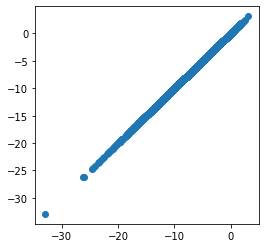

In [28]:
# Plot real vs predicted in training set
plt.figure(figsize=(4,4))
plt.scatter(y_train, y_pred)

In [29]:
# Predict the missing loudness values
X_missing = X_tmp[X_tmp.has_loudness==False].drop(['loudness'], axis=1)
X_missing_scaled = scaler.transform(X_missing)
y_missing = estimator.predict(X_missing_scaled)

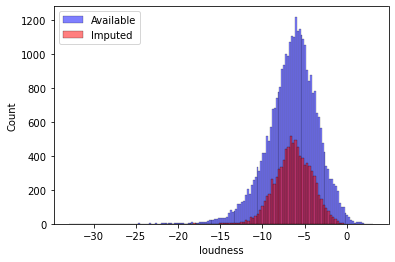

In [30]:
# Plot the distributions
# The seem to be quite 
sns.histplot(y_train, color='b', alpha=0.5)
sns.histplot(y_missing, color='r', alpha=0.5)
plt.legend(['Available', 'Imputed'])
plt.show()

In [31]:
# Assemble the new dataset
X.loc[X_tmp.has_loudness==False, 'loudness'] = y_missing

In [32]:
# Now, there are no missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41975 entries, 0 to 41974
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      41975 non-null  float64
 1   energy            41975 non-null  float64
 2   key               41975 non-null  int64  
 3   loudness          41975 non-null  float64
 4   mode              41975 non-null  int64  
 5   speechiness       41975 non-null  float64
 6   acousticness      41975 non-null  float64
 7   instrumentalness  41975 non-null  float64
 8   liveness          41975 non-null  float64
 9   valence           41975 non-null  float64
 10  tempo             41975 non-null  float64
 11  duration_ms       41975 non-null  int64  
 12  time_signature    41975 non-null  int64  
 13  genre             41975 non-null  object 
 14  text_feature      41975 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 4.8+ MB


### Define Types of Columns

In [33]:
numeric_features = sorted([
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
])

categorical_features = sorted([
    "time_signature",
    "key"
])

binary_features = sorted([
    "mode"
])

nlp_feature = "text_feature"

target = "genre"

### Encode Numericals: Transform if Skewed

This transformation is not needed for all algorithms, but I do it just in case I try someting which requires it.

In [34]:
for col in numeric_features:
    if np.abs(X[col].skew()) > 0.75:
        X[col] = np.log1p(X[col])

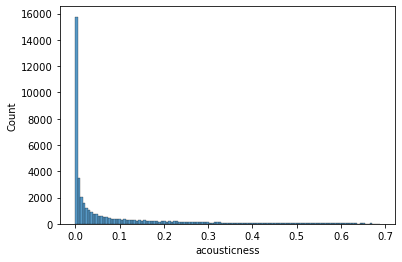

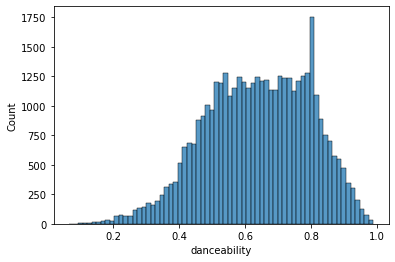

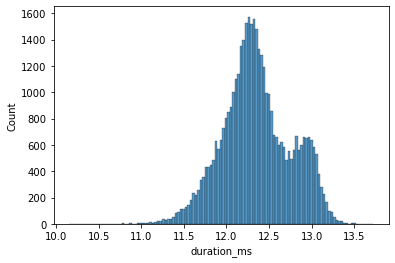

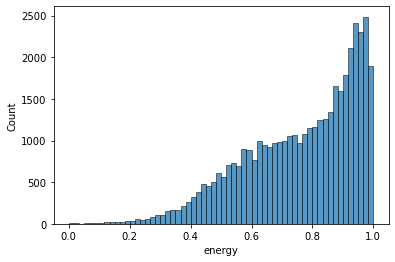

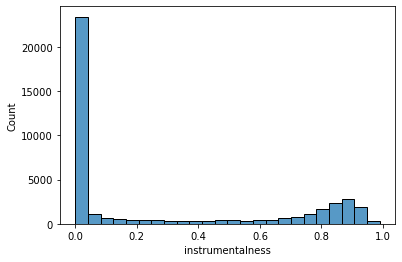

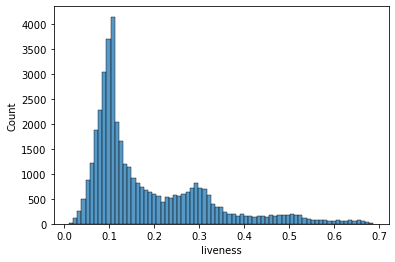

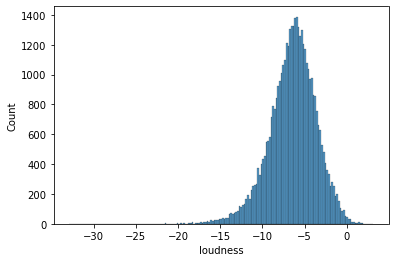

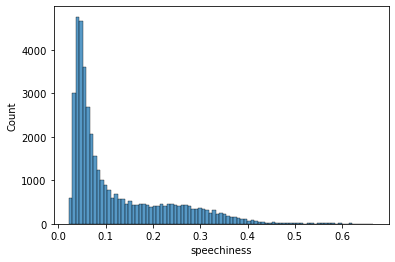

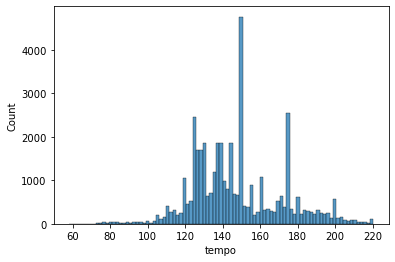

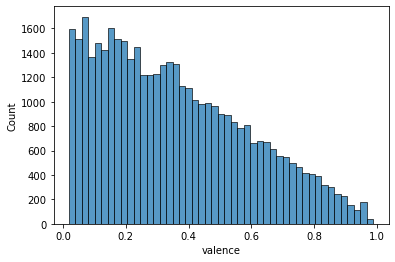

In [35]:
for col in numeric_features:
    sns.histplot(X[col])
    plt.show()

### Encode Categoricals

In [36]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoders = dict()
for col in categorical_features:
    oe = OrdinalEncoder()
    X[col] = oe.fit_transform(X[col].values.reshape(-1, 1))
    ordinal_encoders[col] = oe

### Encode Text Features

In [37]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [38]:
# Distirbution of text_feature word counts
lengths = [len(field[0].split(' ')) for field in X[[nlp_feature]].values]

<AxesSubplot:ylabel='Count'>

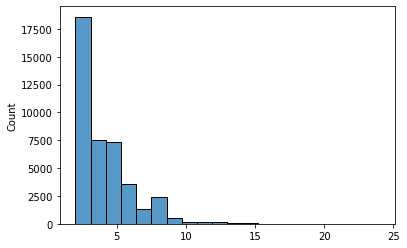

In [39]:
sns.histplot(lengths,bins=20)

In [40]:
# Custom text processing function
def preprocess_text(text):
    text = text.lower()
    # Remove all digits 
    text = re.sub(r'\d+', '', text)
    return text

In [41]:
# TF-IDF
tfidf = TfidfVectorizer(max_features = 500, preprocessor = preprocess_text)
tfidf_mat = tfidf.fit_transform(X[nlp_feature])
# Convert to a dataframe
# TfidfVectorizer normalizes each row to length 1
tfidf_df = pd.DataFrame(tfidf_mat.toarray(), columns = tfidf.get_feature_names_out())
# 1586 rows × 500 columns

In [42]:
tfidf_df

,about,acid,again,ain,album,alive,all,alone,am,and,...,ya,yachty,year,yg,yo,you,young,your,yourself,yung
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Assemble All Columns and Scale

In [43]:
all_features = numeric_features + categorical_features + binary_features # + [nlp_feature]

In [44]:
y = X[target]

In [45]:
X = X[all_features]

In [46]:
X = pd.concat([X, tfidf_df], axis=1).reset_index()

In [47]:
X

,index,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,ya,yachty,year,yg,yo,you,young,your,yourself,yung
0,0,0.058080,0.831,11.732382,0.814,0.013400,0.054109,-7.364000,0.350657,156.985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.337186,0.719,12.321310,0.493,0.000000,0.111541,-7.230000,0.076405,115.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.013706,0.850,11.501076,0.893,0.000004,0.316270,-5.833318,0.060436,218.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.023424,0.476,11.725307,0.781,0.000000,0.107957,-4.710000,0.098034,186.948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.196389,0.798,11.722368,0.624,0.000000,0.153579,-7.668000,0.256965,147.988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41970,41970,0.031014,0.528,12.503243,0.693,0.000345,0.114221,-5.148000,0.029947,150.013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41971,41971,0.022251,0.517,12.255401,0.768,0.000018,0.186480,-7.922000,0.046788,149.928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41972,41972,0.025668,0.361,12.366592,0.821,0.000242,0.325700,-3.102000,0.049266,154.935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41973,41973,0.000551,0.477,12.686030,0.921,0.029600,0.055908,-4.777000,0.038451,150.042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Encode Targets

In [50]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_trans = le.fit_transform(y)

In [51]:
le.classes_

array(['Dark Trap', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal',
       'Underground Rap', 'dnb', 'hardstyle', 'psytrance', 'techhouse',
       'techno', 'trance', 'trap'], dtype=object)

In [52]:
len(le.classes_)

15

## 3. Clustering

### First Approach: K-Means

In [53]:
from sklearn.cluster import KMeans

In [54]:
kmeans = KMeans(n_clusters=15,
                init='k-means++')
# Fit dataset
kmeans.fit(X)

KMeans(n_clusters=15)

In [55]:
# We can predict the clusters of another dataset!
y_pred = kmeans.predict(X)

In [56]:
y_pred

array([12, 12, 12, ...,  7,  7,  7], dtype=int32)

In [57]:
y_trans

array([0, 0, 0, ..., 9, 9, 9])

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

Text(33.0, 0.5, 'True')

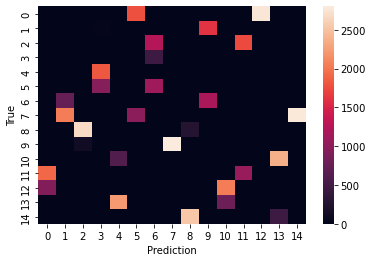

In [59]:
# The confusion matrix is scattered because 
# group and class values are not the same,
# but at least 1-2 columns have the majority of
# rows with large counts.
sns.heatmap(confusion_matrix(y_trans, y_pred))
plt.xlabel('Prediction')
plt.ylabel('True')

In [60]:
cm_true = confusion_matrix(y_trans, y_pred,normalize='true')
print(cm_true.round(2))

[[0.   0.   0.   0.   0.   0.39 0.   0.   0.   0.   0.   0.   0.61 0.
  0.  ]
 [0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.41 0.   0.   0.   0.   0.59 0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.46 0.   0.   0.54 0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.38 0.   0.   0.   0.   0.   0.   0.   0.62 0.   0.   0.   0.
  0.  ]
 [0.   0.35 0.   0.   0.   0.17 0.   0.   0.   0.   0.   0.   0.   0.
  0.48]
 [0.   0.   0.91 0.   0.   0.   0.   0.   0.09 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.96 0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.8
  0.  ]
 [0.64 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.36 0.   0.
  0.  ]
 [0.31 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.69 0.   0

In [61]:
# For each true genre, which is the predicted one?
mapping_true = np.argmax(cm_true, axis=1)
print(mapping_true)

[12  9 11  6  3  6  9 14  2  7 13  0 10  4  8]


In [62]:
len(set(mapping_true))

13

In [63]:
cm_pred = confusion_matrix(y_trans, y_pred, normalize='pred')
print(cm_pred.round(2))

[[0.   0.   0.   0.   0.   0.64 0.   0.   0.   0.   0.   0.   1.   0.
  0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.57 0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.44 0.   0.   0.   0.   0.62 0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.16 0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.65 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.34 0.   0.   0.4  0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.26 0.   0.   0.   0.   0.   0.   0.   0.43 0.   0.   0.   0.
  0.  ]
 [0.   0.74 0.   0.   0.   0.36 0.   0.   0.   0.   0.   0.   0.   0.
  1.  ]
 [0.   0.   0.95 0.   0.   0.   0.   0.   0.09 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.05 0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.21 0.   0.   0.   0.   0.   0.   0.   0.   0.84
  0.  ]
 [0.68 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.38 0.   0.
  0.  ]
 [0.32 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.73 0.   

In [64]:
# For each predicted genre, which is the true one?
mapping_pred = np.argmax(cm_pred, axis=0)
print(mapping_pred)

[11  7  8  4 13  0  2  9 14  1 12  2  0 10  7]


In [65]:
len(set(mapping_pred))

12

In [66]:
# key: predicted
# value: real
mapping = {i:mapping_pred[i] for i in range(len(mapping_pred))}

In [67]:
mapping

{0: 11,
 1: 7,
 2: 8,
 3: 4,
 4: 13,
 5: 0,
 6: 2,
 7: 9,
 8: 14,
 9: 1,
 10: 12,
 11: 2,
 12: 0,
 13: 10,
 14: 7}

In [68]:
y_pred_ = pd.DataFrame(y_pred).replace(mapping).values

In [69]:
map_genre = {i:le.classes_[i] for i in range(len(le.classes_))}
y_pred_genre = pd.DataFrame(y_pred_).replace(map_genre)
y_true_genre = pd.DataFrame(y_trans).replace(map_genre)
genre = pd.concat([y_pred_genre,y_true_genre],axis=1)

In [70]:
genre.columns=['true','prediction']

In [71]:
genre

,true,prediction
0,Dark Trap,Dark Trap
1,Dark Trap,Dark Trap
2,Dark Trap,Dark Trap
3,Dark Trap,Dark Trap
4,Dark Trap,Dark Trap
...,...,...
41970,hardstyle,hardstyle
41971,hardstyle,hardstyle
41972,hardstyle,hardstyle
41973,hardstyle,hardstyle


Text(69.0, 0.5, 'True')

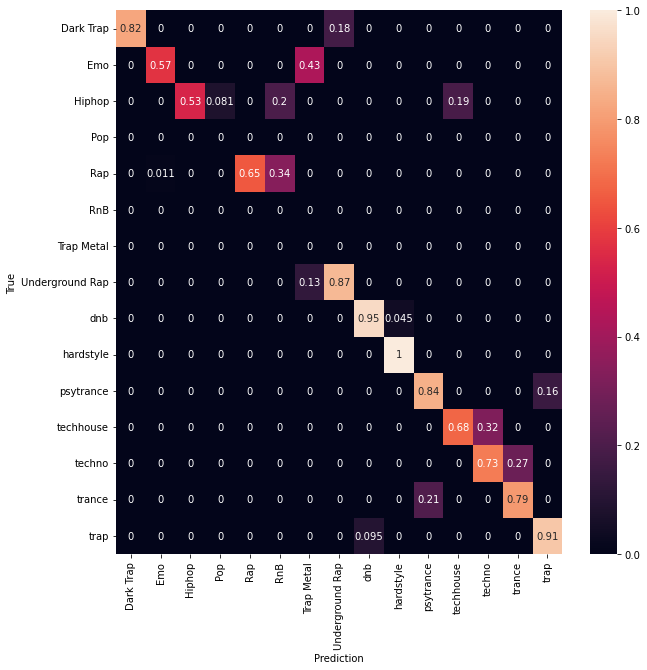

In [72]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(genre['true'], genre['prediction'], normalize='true'),
            annot=True,
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Prediction')
plt.ylabel('True')

In [73]:
print(classification_report(genre['true'], genre['prediction']))

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      Dark Trap       1.00      0.82      0.90      5532
            Emo       0.98      0.57      0.72      2793
         Hiphop       1.00      0.53      0.69      5621
            Pop       0.00      0.00      0.00         0
            Rap       1.00      0.65      0.79      2801
            RnB       0.00      0.00      0.00         0
     Trap Metal       0.00      0.00      0.00         0
Underground Rap       0.83      0.87      0.85      5557
            dnb       0.91      0.95      0.93      2805
      hardstyle       0.96      1.00      0.98      2803
      psytrance       0.80      0.84      0.82      2811
      techhouse       0.64      0.68      0.66      2816
         techno       0.69      0.73      0.71      2816
         trance       0.74      0.79      0.77      2814
           trap       0.85      0.91      0.88      2806

       accuracy                           0.77     41975
      macro avg       0.69   

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

In [75]:
precision_recall_fscore_support(genre['true'], genre['prediction'], average='weighted')[2]

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8093040515797737

#### Define Functions that Do It All

In [76]:
def map_prediction(y_true, y_pred, class_names):
    # Confusion matrix
    cm_pred = confusion_matrix(y_true, y_pred, normalize='pred')
    # For each predicted genre, which is the true one?
    mapping_pred = np.argmax(cm_pred, axis=0)
    # key: predicted, value: real
    mapping = {i:mapping_pred[i] for i in range(len(mapping_pred))}
    # Re-map predicted clusters to original classes
    y_pred_ = pd.DataFrame(y_pred).replace(mapping).values
    # Map labels to original class/genre names
    map_genre = {i:le.classes_[i] for i in range(len(class_names))}
    y_pred_genre = pd.DataFrame(y_pred_).replace(map_genre)
    y_true_genre = pd.DataFrame(y_trans).replace(map_genre)
    # Return data frame with true and predicted genre class values
    genre = pd.concat([y_pred_genre,y_true_genre],axis=1)
    genre.columns=['true','prediction']
    
    return genre
    
def get_f1(genre):
    return precision_recall_fscore_support(genre['true'], genre['prediction'], average='weighted', zero_division=0)[2]

def plot_confusion_matrix(df, class_names):
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(genre['true'], genre['prediction'], normalize='true'),
                annot=True,
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

#### Check the Functions

In [77]:
# Model
kmeans = KMeans(n_clusters=15,
                init='k-means++')
# Fit dataset
kmeans.fit(X)
# Predict
y_pred = kmeans.predict(X)

0.8243199810816817


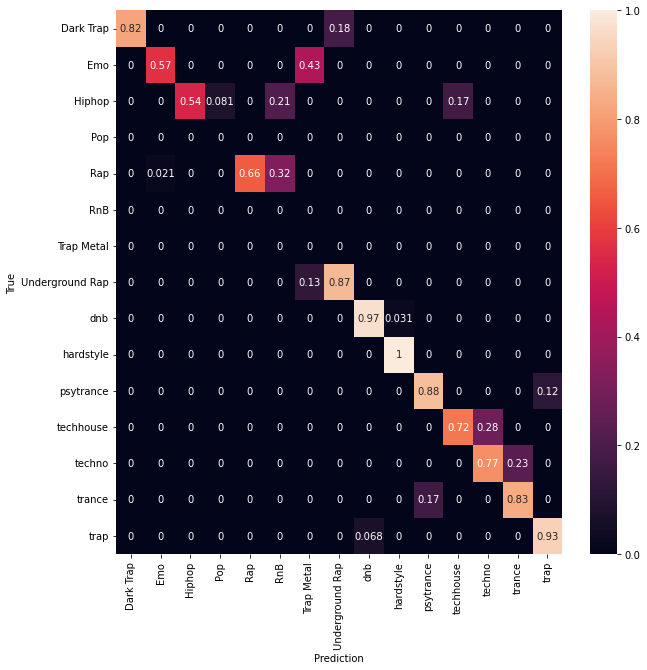

In [78]:
# Evaluate
genre = map_prediction(y_true=y_trans, y_pred=y_pred, class_names=le.classes_)
f1 = get_f1(genre)
print(f1)
plot_confusion_matrix(df=genre, class_names=le.classes_)

### Elbow Method with K-Means

In [79]:
inertia = []
f1s = []
clusters = list(range(5,25))
for k in clusters:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    random_state=10) # always define it!
    kmeans.fit(X)
    # Predict
    y_pred = kmeans.predict(X)
    # F1
    genre = map_prediction(y_true=y_trans, y_pred=y_pred, class_names=le.classes_)
    f1 = get_f1(genre)
    # Store metrics
    inertia.append(kmeans.inertia_)
    f1s.append(f1)

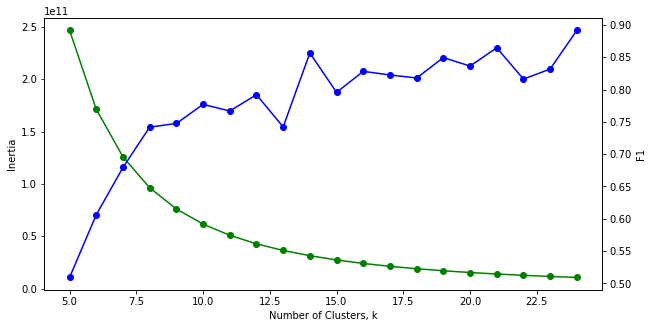

In [80]:
# Plot k vs inertia
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(clusters, inertia, marker='o', color='green')
ax.set_xlabel('Number of Clusters, k')
ax.set_ylabel('Inertia');
# Plot k vs F1
ax2 = ax.twinx()
ax2.plot(clusters, f1s, marker='o', color='blue')
ax2.set_ylabel('F1');
plt.show()

### Varied Clustering Methods

In [81]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

f1s = []

## K-Means
kmeans = KMeans(n_clusters=15,
                init='k-means++',
                random_state=10) # always define it!
kmeans.fit(X)
# Predict
y_pred = kmeans.predict(X)
# F1
genre = map_prediction(y_true=y_trans, y_pred=y_pred, class_names=le.classes_)
f1 = get_f1(genre)
# Store & Print metrics
f1s.append(f1)
print(f'K-means, f1 = {f1}')

## Gaussian Mixtures Model
gmm = GaussianMixture(n_components=15,
                      covariance_type='tied',
                      init_params='kmeans')
gmm.fit(X)
# Predict
y_pred = gmm.predict(X)
# F1
genre = map_prediction(y_true=y_trans, y_pred=y_pred, class_names=le.classes_)
f1 = get_f1(genre)
# Store & Print metrics
f1s.append(f1)
print(f'Gaussian Mixtures, f1 = {f1}')

K-means, f1 = 0.7957040604630805
Gaussian Mixtures, f1 = 0.7117917199374812


In [82]:
## Hierarchical Agglomerative Clustering
agg = AgglomerativeClustering(  n_clusters=15, 
                                affinity='euclidean', # distance metric
                                linkage='ward')
agg.fit(X)

AgglomerativeClustering(n_clusters=15)

In [83]:
# Predict
y_pred = agg.labels_
# F1
genre = map_prediction(y_true=y_trans, y_pred=y_pred, class_names=le.classes_)
f1 = get_f1(genre)
# Store & Print metrics
f1s.append(f1)
print(f'Hierarchical Agglomerative Model, f1 = {f1}')

Hierarchical Agglomerative Model, f1 = 0.8276821370081126


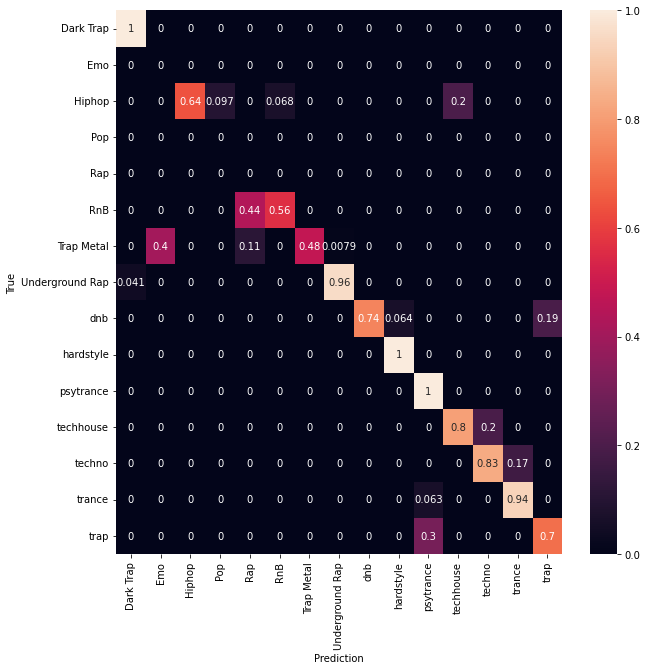

In [84]:
plot_confusion_matrix(df=genre, class_names=le.classes_)

## 4. Dimensionality Reduction for Visualization

In [85]:
def plot_dataset_clusters(X,model=[],num_clusters=0):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'mediumpurple']
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1], c=color[0], alpha=alpha, s=s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[model.labels_==i,0], X[model.labels_==i,1], c=color[i], alpha=alpha, s=s)
            #plt.scatter(model.cluster_centers_[i][0], model.cluster_centers_[i][1], c=color[i], marker = 'x', s = 100)

In [86]:
# TSNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, init='random').fit_transform(X)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


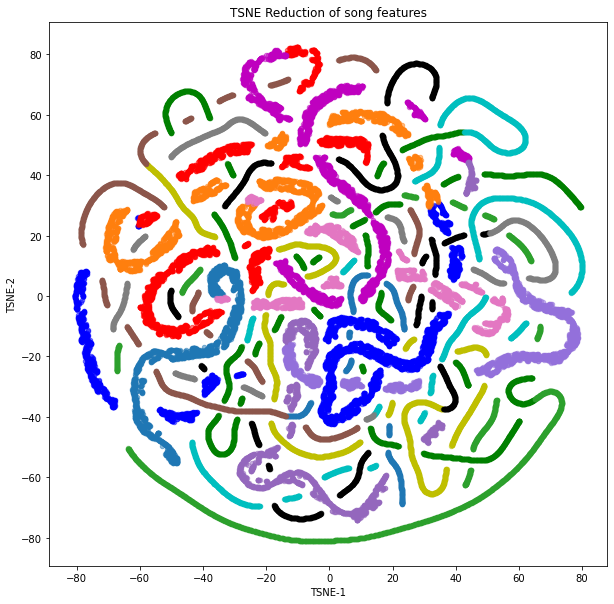

In [87]:
plt.figure(figsize=(10,10))
plot_dataset_clusters(X_tsne,model=agg,num_clusters=15)
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.title('TSNE Reduction of song features')
plt.show()